# Deep Learning Train pipeline

1. Use different data timewindow

2. Show distribution and plots for training set

2. Run it in different deep learning model

## Imports

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from sklearn.metrics import \
    classification_report, \
    plot_confusion_matrix, \
    confusion_matrix, \
    roc_curve, \
    auc, \
    f1_score, accuracy_score, recall_score

## Define Functions and Consts

In [13]:
timewindows = [1, 3, 5, 10, 15, 20, 30]

In [14]:
def load_data(path) -> pd.DataFrame:
    df = pd.read_csv(path)
    return df

def plot_ROC(y_test, y_pred, plt_config):    
        fpr, tpr, threshold = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=plt_config['figsize'])
        plt.title('ROC')
        plt.plot(fpr, tpr, 'b', label='ROC-AUC = %0.2f' % roc_auc)
        plt.plot([0,1], [0,1], 'y--', label='baseline')

        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.legend(loc='best')
        plt.show()

def scalar_normalize(X_train, X_test):
    min_max_scalar = preprocessing.MinMaxScaler()
    X_train_minmax = min_max_scalar.fit_transform(X_train)
    X_test_minmax = min_max_scalar.transform(X_test)
    X_train_scaled = preprocessing.scale(X_train_minmax)
    X_test_scaled = preprocessing.scale(X_test_minmax)
    X_train_normalized = preprocessing.normalize(X_train_scaled, norm='l2')
    X_test_normalized = preprocessing.normalize(X_test_scaled, norm='l2')
    return X_train_normalized, X_test_normalized


In [62]:
def load_windows_data():
    dfs = []
    for t in tqdm(timewindows, desc="Loading Data"):
        path = "../csv_data/user_1_timewindow"+str(t)+".csv"
        dfs.append(load_data(path))
    return dfs

def preprocess_pipeline(dfs):
    ret = []
    for df in tqdm(dfs, desc="Preprocessing"):
        df = df.fillna(-10000)
        # df = df.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
        df = df.replace((np.inf, -np.inf), 0).reset_index(drop=True)
        ret.append(df)
    return ret

def train_test_split_pipeline(dfs, test_size=0.3):
    ret = []
    for df in tqdm(dfs, desc="Spliting"):
        data_X = df.drop(columns = ['timestamp', 'class'])
        data_y = df['class']
        binary_data_y = data_y.copy()
        binary_data_y[binary_data_y>0] = 1
        X_train, X_test, y_train, y_test = train_test_split(data_X, binary_data_y, test_size=test_size)
        ret.append([X_train, X_test, y_train, y_test])
    return ret

def predict_scores(y_true, y_pred):
    accuracy, recall, f1_s = accuracy_score(y_true, y_pred), recall_score(y_true, y_pred), f1_score(y_true, y_pred)
    return accuracy, recall, f1_s

def plot_timewindow_figure(scores, method):
    [accuracy_scores, recall_scores, f1_scores] = scores
    x = timewindows

    plt.plot(x, accuracy_scores, color='r', label='Accuracy')
    plt.plot(x, recall_scores, color='g', label='Recall')
    plt.plot(x, f1_scores, color='b', label='F1 Score')
    plt.xlabel('Time Window')
    plt.ylabel('Score')
    plt.title(method)
    plt.legend(loc="best")
    plt.show()

def prediction_pipeline(data, models):
    clfs = models
    accuracy_scores = []
    recall_scores = []
    f1_scores = []
    for index, [X_train, X_test, y_train, y_test] in enumerate(tqdm(data, desc="Evaluating")):
        clf = clfs[index]
        y_hat = clf.predict(X_test)
        accuracy, recall, f1_s = predict_scores(y_test, y_hat)
        accuracy_scores.append(accuracy)
        recall_scores.append(recall)
        f1_scores.append(f1_s)
    return accuracy_scores, recall_scores, f1_scores

def deepl_prediction_pipeline(data, models):
    clfs = models
    accuracy_scores = []
    recall_scores = []
    f1_scores = []
    for index, [X_train, X_test, y_train, y_test] in enumerate(tqdm(data, desc="Evaluating")):
        clf = clfs[index]
        with torch.no_grad():
            y_hat = clf(Variable(torch.from_numpy(X_test.to_numpy()).type(torch.float))).data.numpy()
        print(y_hat)
        accuracy, recall, f1_s = predict_scores(y_test, y_hat)
        accuracy_scores.append(accuracy)
        recall_scores.append(recall)
        f1_scores.append(f1_s)
    return accuracy_scores, recall_scores, f1_scores
    
def plot_pipeline(scores, method):
    plot_timewindow_figure(scores, method)

def data_preparation_pipeline():
    dfs = load_windows_data()
    dfs = preprocess_pipeline(dfs)
    data = train_test_split_pipeline(dfs, test_size=0.3)
    return data



## Basic information about Datasets

Preprocessing: 100%|██████████| 7/7 [00:00<00:00, 198.11it/s]
Plotting: 7it [00:00, 63.11it/s]


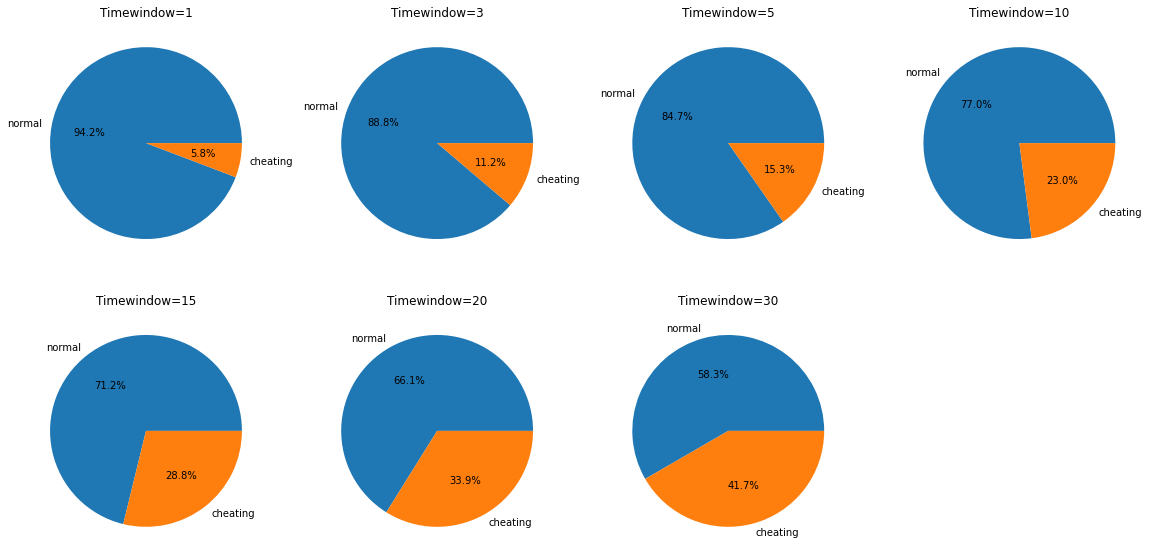

In [16]:
dfs = load_windows_data()
dfs = preprocess_pipeline(dfs)

fig = plt.figure(facecolor='white',figsize=(20, 15))

for index, df in tqdm(enumerate(dfs), "Plotting"):
    cts = df.value_counts(df['class'])
    eplodes = ['normal', 'cheat']
    plt.subplot(3, 4, index+1)
    plt.title("Timewindow="+str(timewindows[index]))
    plt.pie([cts[0], cts[2]], labels=['normal', 'cheating'], autopct='%1.1f%%')
    
plt.show()

## Supervised Learning

### 1. Linear Regression

In [100]:
inputSize = 11
outputSize = 1
lr = 0.01
epochs = 100

In [101]:
class LinearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(LinearRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize)
    def forward(self, x):
        out = self.linear(x)
        return out

def lrTrain(X_train, y_train):
    model = LinearRegression(inputSize, outputSize)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    losses = []
    inputs = Variable(torch.from_numpy(X_train.to_numpy()).type(torch.float))
    yt = y_train.to_numpy().reshape((-1, 1))
    labels = Variable(torch.from_numpy(yt).type(torch.float))
    # inputs = Variable(torch.from_numpy(X_train).type(torch.float))
    # labels = Variable(torch.from_numpy(y_train).type(torch.float))
    for epoch in tqdm(range(epochs), desc="epochs..."):
        # print(np.shape(X_train.to_numpy()), np.shape(yt))
        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, labels)
        losses.append(loss)
        loss.backward()
        optimizer.step()
        # print('epoch {}, loss {}'.format(epoch, loss))
    return model

def linear_regression_pipeLine():
    data = data_preparation_pipeline()
    clfs = []
    # training
    for [X_train, X_test, y_train, y_test] in data:
        clf = lrTrain(X_train, y_train)
        clfs.append(clf)
    # testing
    accuracy_scores, recall_scores, f1_scores = deepl_prediction_pipeline(data, clfs)
    plot_pipeline([accuracy_scores, recall_scores, f1_scores], method="Decision Tree")

In [102]:
linear_regression_pipeLine()

# create dummy data for training
# x_values = [i for i in range(11)]
# x_train = np.array(x_values, dtype=np.float32)
# x_train = x_train.reshape(-1, 1)

# y_values = [2*i + 1 for i in x_values]
# y_train = np.array(y_values, dtype=np.float32)
# y_train = y_train.reshape(-1, 1)

# clf = lrTrain(x_train, y_train)
# with torch.no_grad():
#     predicted = clf(Variable(torch.from_numpy(x_train))).data.numpy()
# print(predicted)

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').